# Assignment 4
## Anton Marin
### Task 1
Some imports first

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

I have copied table with b coefficients, depending on A and alpha to a separate file for convinience.

In [2]:
with open('Amplitudes.txt', 'r') as f:
    lines = f.readlines()
    amplitudes = np.array([[float(value) for value in row.split()] for row in lines])

Select b coefficients given m and n - number of A or alpha

In [3]:
def get_b(amplitudes, m, n):
    return amplitudes[4*m:4*(m+1), n]

In [4]:
def deg_to_rad(deg):
    return deg*np.pi/180

Main function for calculating latitudes

In [5]:
def get_theta(AL, t, m, amplitudes):
    def get_A(i, m, amplitudes):
        b = get_b(amplitudes, m, i)
        res = 0
        for j in range(4):
            res += b[j]*(np.log10(abs(AL))**j)
        return res
    
    def get_alpha(i, m, amplitudes):
        b = get_b(amplitudes, m, 4+i-1)
        res = 0
        for j in range(4):
            res += b[j]*(np.log10(abs(AL))**j)
        return res
    
    res = 0
    for j in range(4):
        A = get_A(j, m, amplitudes)
        if j==0:
            cos_ = 1
        else:
            cos_ = np.cos(deg_to_rad(15*(j*t + get_alpha(j, m, amplitudes))))
        res += A*cos_
    return 90-res

Setting range of target ALs and times

In [7]:
AL_s = [-10 if i==0 else -100*(i)for i in range(9)]
t_s = [i for i in range(24)]

plotting

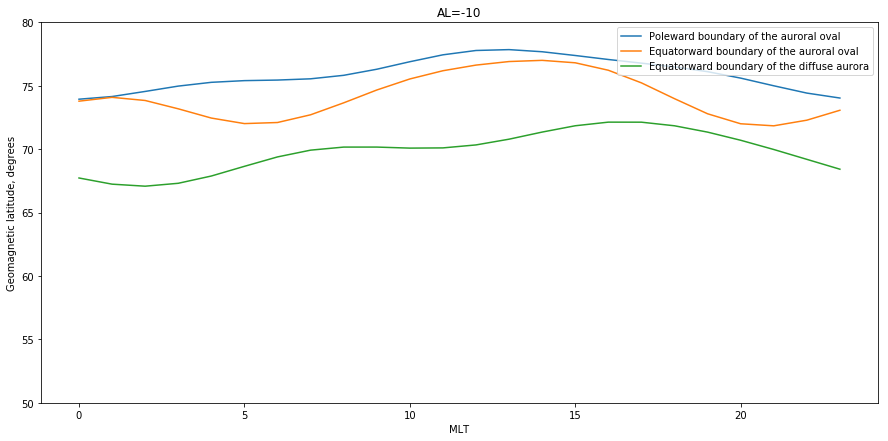

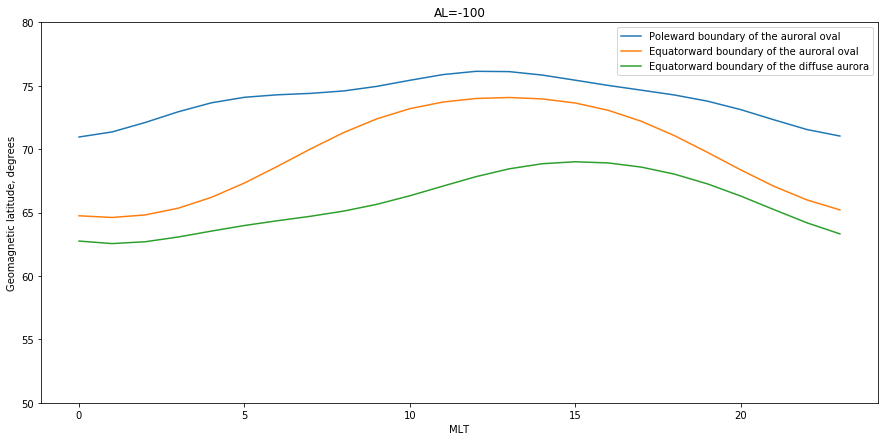

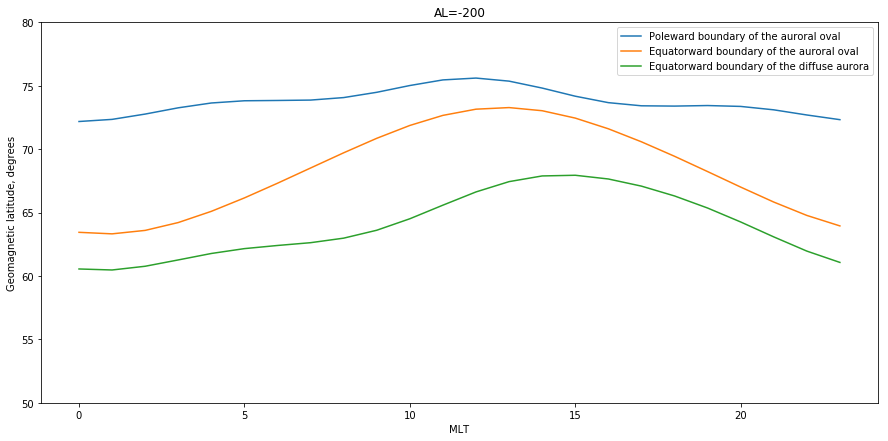

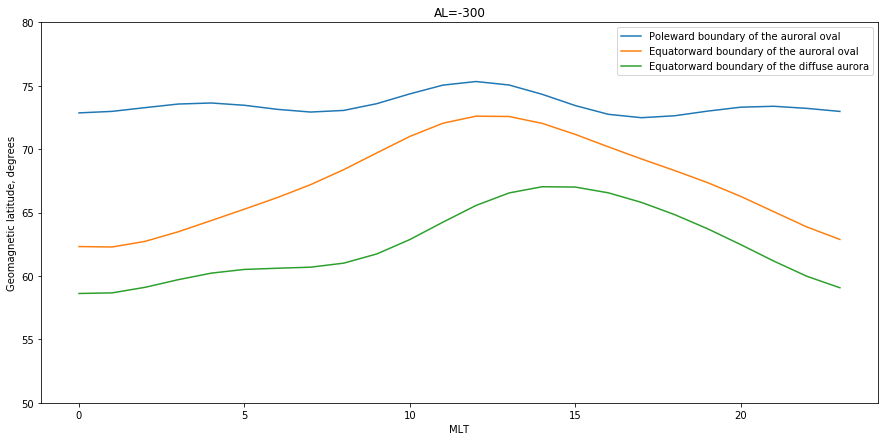

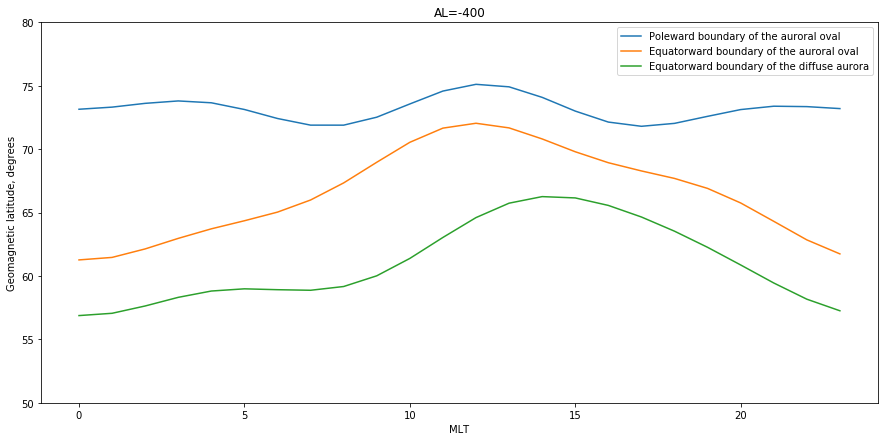

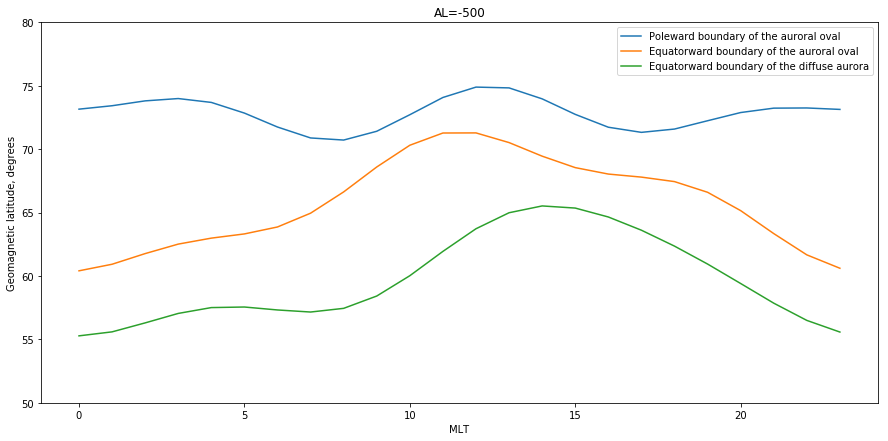

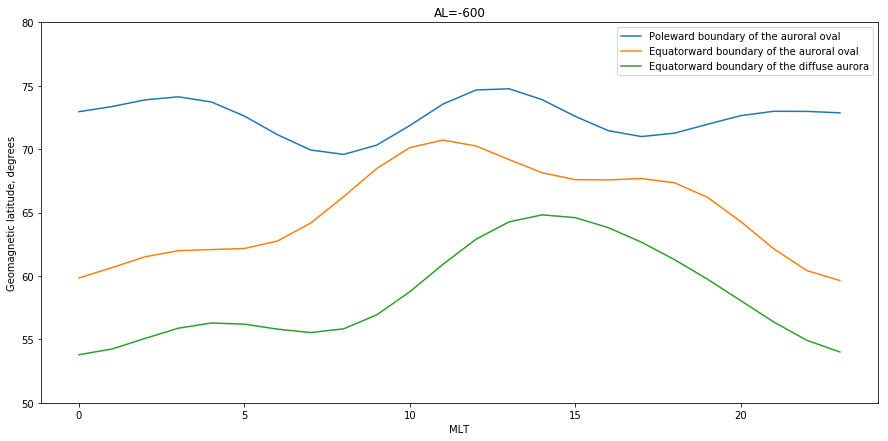

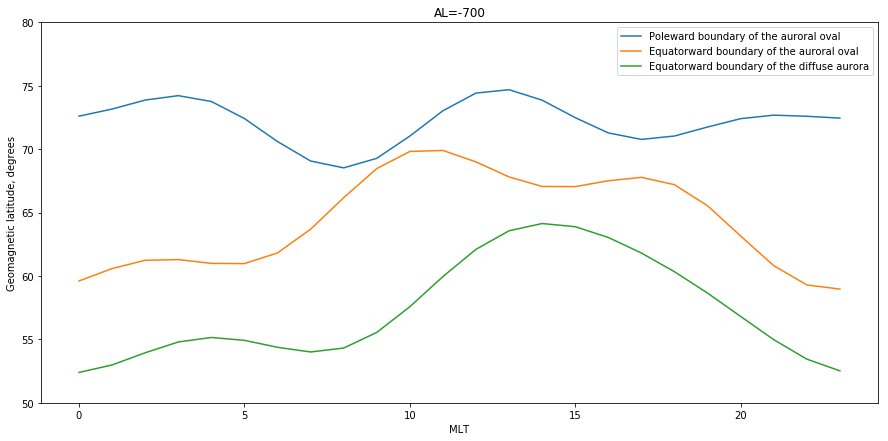

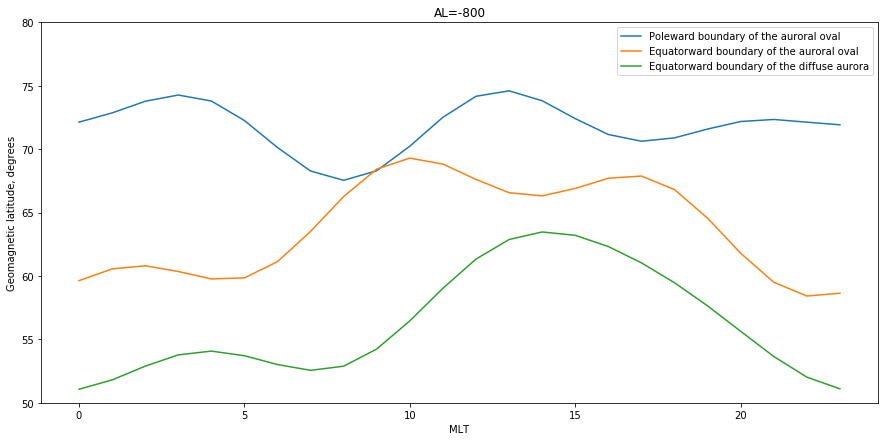

In [8]:
for AL in AL_s:
    plt.figure(figsize=(15,7))
    plt.title('AL={}'.format(AL))
    pwbao = [get_theta(AL, t, 0, amplitudes) for t in t_s]
    ewbao = [get_theta(AL, t, 1, amplitudes) for t in t_s]
    ewbda = [get_theta(AL, t, 2, amplitudes) for t in t_s]
    plt.plot(t_s, pwbao, label='Poleward boundary of the auroral oval')
    plt.plot(t_s, ewbao, label='Equatorward boundary of the auroral oval')
    plt.plot(t_s, ewbda, label='Equatorward boundary of the diffuse aurora')
    plt.xlabel('MLT')
    plt.ylabel('Geomagnetic latitude, degrees')
    plt.legend(loc='upper right')
    plt.ylim((50, 80))
    plt.show()

### Conclusion
1. As AL absolute values are higher, polar aurora's ovals move closer to equator, as the intersity of magnetic field increases
2. During magnetic night hours, polar aurora moves closer to equator, as magnetic lines of Earth block solar wind from front side, discard them behids the Earth and the energy enters Earth from the reserve side of magnetic field


### Task 2
reading and parsing data

In [10]:
with open('omni2_9888.lst', 'r') as f:
    lines = f.readlines()

In [11]:
data = np.array([[float(value) for value in line.split()] for line in lines])

In [12]:
By = data[:, 3]
Bz = data[:, 4]
V = data[:, 5]
KP = data[:, 6]/10
AL = data[:, 7]

Calculation of AL using KP index

In [13]:
AL_Kp = -np.array(list(map(lambda x: 18 - 12.3 * x + 27.2 * x**2 - 2.0 * x**3, KP)))

Calculation of AL using solar wind.
Defining E function

In [14]:
def get_E(By, Bz, V):
    assert By.shape == Bz.shape == V.shape
    E = np.zeros(By.shape)
    theta_prev=np.nan
    for i in range(By.shape[0]):
        if By[i] == Bz[i]:
            theta = theta_prev
        else:
            theta = np.arccos(Bz[i]/(By[i]**2 + Bz[i]**2)**0.5)
            theta_prev = theta
        E[i] = V[i] * ((By[i]**2) / 2 + Bz[i]**2)**0.5 * np.sin(theta/2)**4 + 0.0044 * V[i]**2 * np.sin(theta/2)**0.5
    return E

In [15]:
E = get_E(By, Bz, V)

Calculation of E185

In [16]:
E185 = np.zeros(E.shape)

for i in range(2, E.shape[0]):
    E185[i] = (E[i-2] + 8*E[i-1] + 5*E[i])/14

Preparing E185 and respective AL: ignoring first two measurements

In [17]:
E_185_ltsq = E185[2:].reshape(-1, 1)
AL_ltsq = AL[2:]

In [20]:
A = np.hstack([np.log10(E_185_ltsq)**i for i in range(5)])

In [21]:
B = AL_ltsq

Solving least squares problem for obtaining c coefficients

In [24]:
c = np.linalg.lstsq(A, B)[0]

Recalculating AL using obtained c coefficients

In [25]:
AL_SW = np.dot(A,c)

Resulted AL from solar wind

In [26]:
AL_SW

array([-157.5106223 , -171.12074308, -127.08907865, ..., -777.68004389,
       -790.2165566 , -784.10819888])

Resulted AL from Kp index

In [30]:
AL_Kp

array([ 109.264,  109.264,  109.264, ...,  461.232,  461.232,  461.232])

Ground truth

In [27]:
AL

array([  -9.,   -7.,  -57., ..., -968., -680., -783.])

Calculation of std between obtained results and GT

In [28]:
np.std(AL_SW - AL[2:])

89.990162563194318

In [29]:
np.std(-AL_Kp[2:] - AL[2:])

108.61245187713493

Plotting last 50 values

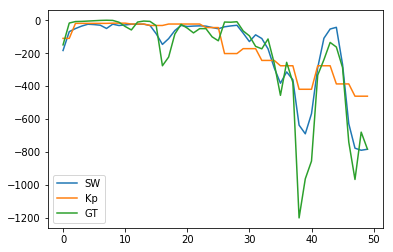

In [36]:
plt.plot(AL_SW[-50:], label='SW')
plt.plot(-AL_Kp[-50:], label='Kp')
plt.plot(AL[-50:], label='GT')
plt.legend()

### Conclusion
Calculation of AL using solar wind is a more accurate method than KP, as it finds out c coefficients from historical data and adopts them, while c coefficients in KP method are fixed for all KP values. However, there is a place for improvement of this method